In [1]:
%matplotlib inline
import lightgbm as lgb
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool
import subprocess
import matplotlib.pyplot as plt
import os
import time
from sklearn.model_selection import TimeSeriesSplit, KFold, StratifiedKFold
from features import get_features

/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Load Data

In [2]:
df_train = pd.read_csv("input/parsed_train.csv", dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv("input/parsed_test.csv", dtype={'fullVisitorId': 'str'})

/Users/hyundai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Feature Engineering

In [3]:
# df_train = get_features(df_train)
# df_test = get_features(df_test)

### Split X and y, Remove not_used_cols

In [4]:
target_col = 'totals_transactionRevenue'
df_train_y = df_train[target_col].astype(float)
df_train_y.fillna(0, inplace=True)
df_train_y = np.log1p(df_train_y)

In [5]:
not_used_cols = [
    "visitNumber", "date", "fullVisitorId", "sessionId", "visitId",
    "visitStartTime", 'trafficSource_referralPath',
    'trafficSource_campaignCode', target_col,
]
df_train_idx = df_train[['fullVisitorId']]
df_train_X = df_train.drop(not_used_cols, axis=1)

df_test_idx = df_test[['fullVisitorId']]
del_cols = list(set(df_test.columns) & set(not_used_cols))
df_test_X = df_test.drop(del_cols, axis=1)

In [6]:
print(df_train_X.columns)
print(df_test_X.columns)

Index(['channelGrouping', 'socialEngagementType', 'device_browser',
       'device_browserSize', 'device_browserVersion', 'device_deviceCategory',
       'device_flashVersion', 'device_isMobile', 'device_language',
       'device_mobileDeviceBranding', 'device_mobileDeviceInfo',
       'device_mobileDeviceMarketingName', 'device_mobileDeviceModel',
       'device_mobileInputSelector', 'device_operatingSystem',
       'device_operatingSystemVersion', 'device_screenColors',
       'device_screenResolution', 'geoNetwork_city', 'geoNetwork_cityId',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_latitude',
       'geoNetwork_longitude', 'geoNetwork_metro', 'geoNetwork_networkDomain',
       'geoNetwork_networkLocation', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_visits',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficS

### Label Encoding

In [7]:
categorical_feature = list(df_train_X.select_dtypes(exclude=np.number).columns)
# print(categorical_feature)

df_train_X[categorical_feature].fillna('NA_NULL', inplace=True)
df_train_X.fillna(0, inplace=True)

df_test_X[categorical_feature].fillna('NA_NULL', inplace=True)
df_test_X.fillna(0, inplace=True)

for c in categorical_feature:
    st = time.time()
    lbl = LabelEncoder()
    lbl.fit(
        list(df_train_X[c].values.astype('str')) +
        list(df_test_X[c].values.astype('str')))
    df_train_X[c] = lbl.transform(list(df_train_X[c].values.astype('str')))
    df_test_X[c] = lbl.transform(list(df_test_X[c].values.astype('str')))
    print(c, time.time() - st)

/Users/hyundai/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


channelGrouping 5.800209999084473
socialEngagementType 6.6980767250061035
device_browser 9.436944961547852
device_browserSize 7.734472990036011
device_browserVersion 6.880335330963135
device_deviceCategory 4.626874923706055
device_flashVersion 6.763077735900879
device_isMobile 4.207995176315308
device_language 6.712721824645996
device_mobileDeviceBranding 6.714668035507202
device_mobileDeviceInfo 7.370935678482056
device_mobileDeviceMarketingName 7.179858922958374
device_mobileDeviceModel 6.60375189781189
device_mobileInputSelector 7.236102104187012
device_operatingSystem 5.657855033874512
device_operatingSystemVersion 7.087792873382568
device_screenColors 6.962395906448364
device_screenResolution 6.569489240646362
geoNetwork_city 7.338249921798706
geoNetwork_cityId 6.560302019119263
geoNetwork_continent 4.464140176773071
geoNetwork_country 5.912215709686279
geoNetwork_latitude 6.483771800994873
geoNetwork_longitude 6.494608163833618
geoNetwork_metro 8.550843000411987
geoNetwork_networ

### Training with CV

In [8]:
prediction = np.zeros(df_test_X.shape[0])
prediction_train = np.zeros(df_train_X.shape[0])
N_SPLITS = 5
folds = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=7)
binsplits = np.arange(2,24,2)
y_categorized = np.digitize(df_train_y.values, bins=binsplits)

fold_cols = []
# for fold_n, (train_index, test_index) in enumerate(folds.split(df_train_X)):
for fold_n, (train_index, test_index) in enumerate(folds.split(df_train_X, y_categorized)):
    print('Fold:', fold_n)
    X_train, X_valid = df_train_X.iloc[train_index], df_train_X.iloc[test_index]
    y_train, y_valid = df_train_y.iloc[train_index], df_train_y.iloc[test_index]
    
    feature_name = list(df_train_X.columns)

    train = lgb.Dataset(
        X_train.values,
        label=y_train.values,
        feature_name=feature_name,
        categorical_feature=categorical_feature)

    valid = lgb.Dataset(
        X_valid.values,
        label=y_valid.values,
        feature_name=feature_name,
        categorical_feature=categorical_feature)
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "max_depth": 8,
        "min_child_samples": 20,
        "reg_alpha": 1,
        "reg_lambda": 1,
        "num_leaves": 257,
        "learning_rate": 0.01,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "subsample_freq ": 5,
    }
    evals_result = {}
    train_params = {
        'params': params,
        'train_set': train,
        'valid_sets': [train, valid],
        'valid_names': ['train', 'valid'],
        'early_stopping_rounds': 100,  #50
        'num_boost_round': 1000,  #500
        'verbose_eval': 25,
        'feval': None,
        'evals_result':evals_result,
        #     'categorical_feature': 'auto',
    }


    model = lgb.train(**train_params)    
    
    fold_col = 'fold_{}'.format(fold_n)
    fold_cols.append(fold_col)

    print('predict test set')
    y_pred = model.predict(df_test_X, num_iteration=model.best_iteration)
    prediction += y_pred
    df_test_idx[fold_col] = y_pred
    
    print('predict train set')
    y_pred_train = model.predict(df_train_X, num_iteration=model.best_iteration)
    prediction_train += y_pred_train
    df_train_idx[fold_col] = y_pred_train

# df_test_idx['fold_avg'] = prediction / N_SPLITS
# df_train_idx['fold_avg'] = prediction_train / N_SPLITS
df_train_idx['y_true'] = df_train_y.values
df_train_idx['fold_avg'] = df_train_idx[fold_cols].mean(axis=1)
df_train_idx['fold_max'] = df_train_idx[fold_cols].max(axis=1)

df_test_idx['fold_avg'] = df_test_idx[fold_cols].mean(axis=1)
df_test_idx['fold_max'] = df_test_idx[fold_cols].max(axis=1)

/Users/hyundai/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Fold: 0


/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1158: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/hyundai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:725: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[25]	train's rmse: 1.87645	valid's rmse: 1.88061
[50]	train's rmse: 1.79963	valid's rmse: 1.80767
[75]	train's rmse: 1.73762	valid's rmse: 1.75051
[100]	train's rmse: 1.69491	valid's rmse: 1.71294
[125]	train's rmse: 1.66413	valid's rmse: 1.68727
[150]	train's rmse: 1.6427	valid's rmse: 1.67106
[175]	train's rmse: 1.62606	valid's rmse: 1.65964
[200]	train's rmse: 1.61306	valid's rmse: 1.65188
[225]	train's rmse: 1.60199	valid's rmse: 1.64621
[250]	train's rmse: 1.59275	valid's rmse: 1.64197
[275]	train's rmse: 1.58507	valid's rmse: 1.63876
[300]	train's rmse: 1.57857	valid's rmse: 1.63647
[325]	train's rmse: 1.57322	valid's rmse: 1.63527
[350]	train's rmse: 1.56796	valid's rmse: 1.63419
[375]	train's rmse: 1.5635	valid's rmse: 1.63344
[400]	train's rmse: 1.55954	valid's rmse: 1.6329
[425]	train's rmse: 1.55627	valid's rmse: 1.63252
[450]	train's rmse: 1.55368	valid's rmse: 1.63239
[475]	train's rmse: 1.55114	valid's rmse: 1

/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


predict train set


/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold: 1
Training until validation scores don't improve for 100 rounds.
[25]	train's rmse: 1.87671	valid's rmse: 1.8799
[50]	train's rmse: 1.7999	valid's rmse: 1.80769
[75]	train's rmse: 1.73794	valid's rmse: 1.75048
[100]	train's rmse: 1.69578	valid's rmse: 1.71273
[125]	train's rmse: 1.66547	valid's rmse: 1.68715
[150]	train's rmse: 1.64417	valid's rmse: 1.67078
[175]	train's rmse: 1.62733	valid's rmse: 1.65865
[200]	train's rmse: 1.61435	valid's rmse: 1.65058
[225]	train's rmse: 1.60314	valid's rmse: 1.64437
[250]	train's rmse: 1.5939	valid's rmse: 1.63996
[275]	train's rmse: 1.58603	valid's rmse: 1.6361
[300]	train's rmse: 1.57972	valid's rmse: 1.63349
[325]	train's rmse: 1.57418	valid's rmse: 1.63144
[350]	train's rmse: 1.56893	valid's rmse: 1.62972
[375]	train's rmse: 1.56458	valid's rmse: 1.62848
[400]	train's rmse: 1.56077	valid's rmse: 1.62764
[425]	train's rmse: 1.55748	valid's rmse: 1.62709
[450]	train's rmse: 1.55484	valid's rmse: 1.62685
[475]	train's rmse: 1.55233	valid's 

/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [9]:
df_train_idx

,fullVisitorId,fold_0,fold_1,fold_2,fold_3,fold_4,y_true,fold_avg,fold_max
0,1131660440785968503,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
1,377306020877927890,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
2,3895546263509774583,-0.001156,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000122,0.002067
3,4763447161404445595,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
4,27294437909732085,-0.000440,-0.000233,-0.000212,0.002403,0.001373,0.0,0.000578,0.002403
5,2938943183656635653,-0.001156,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000122,0.002067
6,1905672039242460897,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
7,537222803633850821,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
8,4445454811831400414,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
9,9499785259412240342,-0.001156,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000122,0.002067


In [10]:
df_test_idx.head(20)

,fullVisitorId,fold_0,fold_1,fold_2,fold_3,fold_4,fold_avg,fold_max
0,6167871330617112363,0.073948,0.086177,-0.000212,0.058637,0.068878,0.057486,0.086177
1,0643697640977915618,-0.000371,-0.000063,0.000053,0.003174,0.001989,0.000956,0.003174
2,6059383810968229466,0.001419,0.000982,0.002170,0.007262,0.004457,0.003258,0.007262
3,2376720078563423631,0.000273,0.011338,0.004339,0.011163,0.007774,0.006977,0.011338
4,2314544520795440038,0.003093,0.003693,-0.002890,0.001076,0.000382,0.001071,0.003693
5,4133039884103392367,-0.004589,-0.005534,-0.013383,-0.003087,-0.009702,-0.007259,-0.003087
6,4320478850207397557,0.948086,1.027337,1.251166,1.356365,0.497653,1.016121,1.356365
7,5876438247590157131,0.183456,-0.274694,-0.437262,0.811844,0.386614,0.133991,0.811844
8,0514591268737702944,0.002403,0.001324,0.002097,0.004484,0.003179,0.002697,0.004484
9,6430567031531677212,-0.000371,-0.000063,0.000053,0.003174,0.001989,0.000956,0.003174


In [11]:
df_train_idx[df_train_idx['y_true'] > 0]

,fullVisitorId,fold_0,fold_1,fold_2,fold_3,fold_4,y_true,fold_avg,fold_max
752,6194193421514403509,3.045628,3.416152,4.865018,3.959266,3.860954,17.449406,3.829403,4.865018
753,5327166854580374902,2.885186,2.200188,2.236665,2.445755,3.000376,19.541283,2.553634,3.000376
799,8885051388942907862,5.657316,5.557106,5.025929,5.615520,5.208869,18.035459,5.412948,5.657316
802,0185467632009737931,3.169207,2.882161,3.279332,2.863318,3.295694,17.083177,3.097942,3.295694
859,3244885836845029978,6.971802,7.598819,7.011912,6.972666,6.362648,20.168401,6.983570,7.598819
866,3351538799616866750,4.962956,4.539351,4.488553,5.005254,4.225938,15.941359,4.644410,5.005254
893,1776658355119092313,2.796537,3.338254,2.934503,3.081598,3.174220,19.796243,3.065022,3.338254
910,770431600902969839,6.303486,5.985153,5.956932,6.244734,6.435884,16.996892,6.185238,6.435884
922,7147112211830167925,0.696265,0.793148,0.539639,-0.003252,1.048371,17.384480,0.614834,1.048371
925,6664733704830724714,4.507165,3.792075,4.542504,4.775095,4.496638,17.373142,4.422696,4.775095


In [12]:
df_train_idx[(df_train_idx['y_true'] <= 0) & (df_train_idx['fold_avg'] > 0)]

,fullVisitorId,fold_0,fold_1,fold_2,fold_3,fold_4,y_true,fold_avg,fold_max
0,1131660440785968503,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
1,377306020877927890,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
2,3895546263509774583,-0.001156,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000122,0.002067
3,4763447161404445595,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
4,27294437909732085,-0.000440,-0.000233,-0.000212,0.002403,0.001373,0.0,0.000578,0.002403
5,2938943183656635653,-0.001156,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000122,0.002067
6,1905672039242460897,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
7,537222803633850821,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
8,4445454811831400414,-0.001108,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000132,0.002067
9,9499785259412240342,-0.001156,-0.000802,-0.000638,0.002067,0.001140,0.0,0.000122,0.002067


### Prediction

In [13]:
# y_pred_train = df_train_idx['fold_avg'].values
# y_pred = df_test_idx['fold_avg'].values

y_pred_train = df_train_idx['fold_max'].values
y_pred = df_test_idx['fold_max'].values

### Report

In [14]:
# Init result configurations
RESULT_PATH = 'results'

time_tag = datetime.datetime.now().strftime('%Y-%m-%dT%H%M%S')
rmse_tag = 'T{0:.3f}_V{0:.3f}_K'.format(model.best_score['train']['rmse'], model.best_score['valid']['rmse'])
result_path = os.path.join(RESULT_PATH, '{}__{}'.format(time_tag, rmse_tag))

os.makedirs(result_path, exist_ok=True)
# Create train set raw result file
df_res = df_train_idx.copy()
df_res['y_true'] = df_train_y.values
df_res['y_pred'] = y_pred_train
file_name = 'reg_train_{}.csv'.format(time_tag)
df_res.to_csv(os.path.join(result_path, file_name), index=False)
print('raw_train:', os.path.join(result_path, file_name))

# Create train set raw result file
df_res = df_test_idx.copy()
df_res['y_pred'] = y_pred
file_name = 'reg_test_{}.csv'.format(time_tag)
df_res.to_csv(os.path.join(result_path, file_name), index=False)
print('raw_test:', os.path.join(result_path, file_name))

# Create submit file
df_test_idx['PredictedLogRevenue'] = 0
df_test_idx['PredictedLogRevenue'] = y_pred
df_test_idx["PredictedLogRevenue"] = df_test_idx["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
df_test_idx["PredictedLogRevenue"] = df_test_idx["PredictedLogRevenue"].fillna(0.0)
df_test_idx["PredictedLogRevenue"] = np.expm1(df_test_idx["PredictedLogRevenue"])

df_submit = df_test_idx[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
df_submit["PredictedLogRevenue"] = np.log1p(df_submit["PredictedLogRevenue"])

file_name = 'aiden_{}.csv.tar.gz'.format(time_tag)
df_submit.to_csv(os.path.join(result_path, file_name), index=False, compression='gzip')
print('submit:', os.path.join(result_path, file_name))

# Write MSG
msg = []
msg.append(str(df_train_X.columns))
# del train_params['evals_result']
# del train_params['valid_sets']
msg.append(str(train_params))

with open(os.path.join(result_path, 'result.log'), 'w') as f:
    f.write('\n'.join(msg))

# Copy notebook to results for history
cmd = """cp -f {notebook_name} {result_path}/{notebook_name}
""".format(**{'notebook_name': 'reg_lgbm.ipynb', 'result_path': result_path})
print(cmd)
subprocess.call(cmd, shell=True)


raw_train: results/2018-09-25T215727__T1.551_V1.551_K/reg_train_2018-09-25T215727.csv
raw_test: results/2018-09-25T215727__T1.551_V1.551_K/reg_test_2018-09-25T215727.csv


/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hyundai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

submit: results/2018-09-25T215727__T1.551_V1.551_K/aiden_2018-09-25T215727.csv.tar.gz
cp -f reg_lgbm.ipynb results/2018-09-25T215727__T1.551_V1.551_K/reg_lgbm.ipynb



0

In [15]:
df_submit

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.356107
1,0000049363351866189,0.006773
2,0000053049821714864,0.007866
3,0000059488412965267,0.005578
4,0000085840370633780,0.022296
5,0000091131414287111,0.002039
6,0000117255350596610,6.157386
7,0000118334805178127,0.001598
8,0000130646294093000,0.002067
9,0000150005271820273,0.003174


### Feature Importance

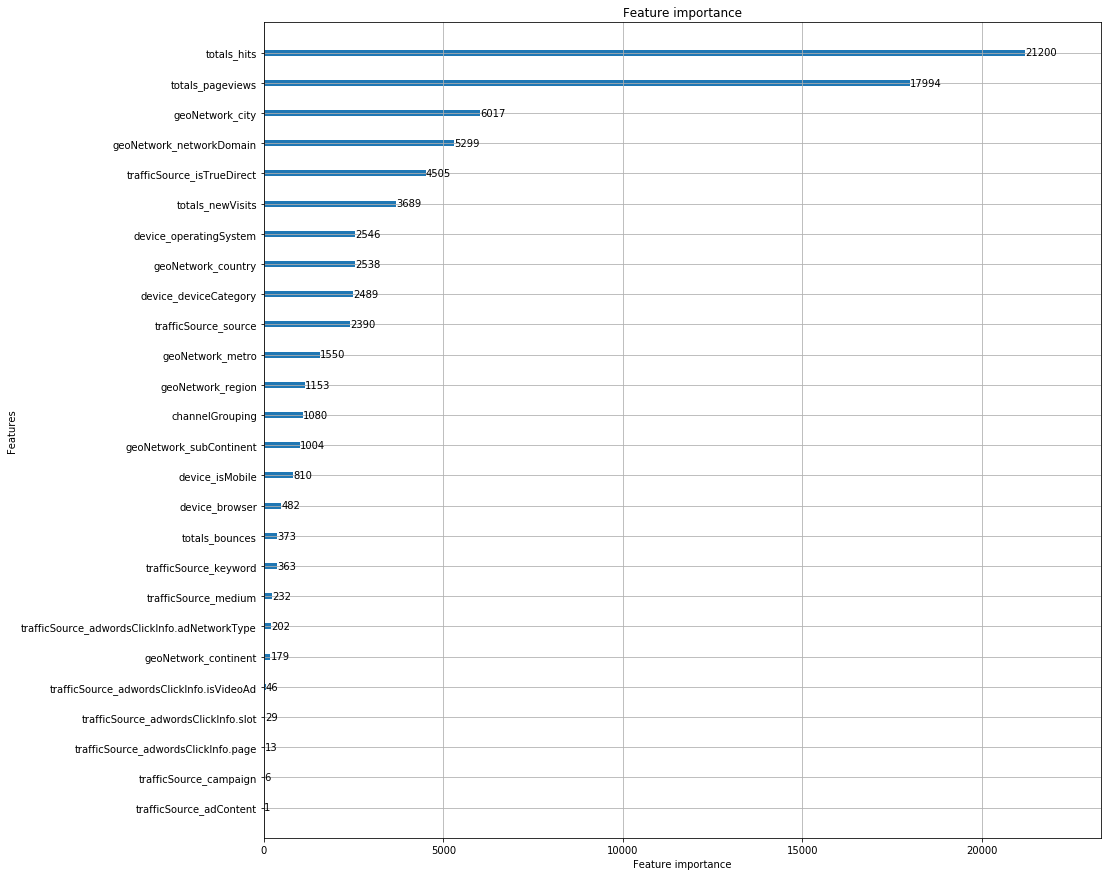

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(model, ax=ax, max_num_features=30)  
plt.savefig(os.path.join(result_path, 'feature_importance.jpg'))

### to Kaggle with MSG

In [17]:
# cmd = """kaggle competitions submit -c ga-customer-revenue-prediction -f {file_path} -m "{msg}"
# """.format(**{'file_path': os.path.join(result_path, file_name), 'msg': ','.join(msg)[:500]})
# print(cmd)
# subprocess.call(cmd, shell=True)